## Bus Arrival Time Prediction and Real Time Updating 
##### Group 27

##### Dwell time Prediction Model


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dwell-time-data/bus_stop_times_poi_data_added_modified.csv


In [2]:
# import libraries

import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import shap
%matplotlib inline


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
# read the dataset - running times
dwell_time_data = pd.read_csv('/kaggle/input/dwell-time-data/bus_stop_times_poi_data_added_modified.csv')

In [4]:
dwell_time_data.head()

,Unnamed: 0,trip_id,deviceid,direction,bus_stop,date,arrival_time,departure_time,dwell_time,dwell_time_in_seconds_old,...,dwell_time_in_seconds,place_of_worship,place_of_education,hospital,tourist_attractions,commercial_places,public_places,nearby_bus_stops,total_poi_count,average_poi_distance
0,0,1,262,1,101,2021-10-01,06:40:58,06:42:12,0:01:14,74.0,...,74.0,3,1,0,23,1,7,1,13,0.002210
1,1,1,262,1,102,2021-10-01,06:45:42,06:45:42,0:00:00,0.0,...,0.0,0,8,0,2,0,1,0,6,0.002406
2,2,1,262,1,103,2021-10-01,06:53:58,06:54:04,0:00:06,6.0,...,6.0,4,0,0,2,0,1,0,5,0.002081
3,3,1,262,1,104,2021-10-01,06:57:19,06:57:19,0:00:00,0.0,...,0.0,2,0,0,1,0,1,0,3,0.001165
4,4,1,262,1,105,2021-10-01,06:58:56,07:02:27,0:03:31,211.0,...,211.0,2,1,0,0,0,2,0,3,0.001913


In [5]:
#filter non brief stops from the dataset
dwell_time_data = dwell_time_data.drop(dwell_time_data[dwell_time_data['stop_type']=='br'].index)

In [6]:
dwell_time_data.columns

Index(['Unnamed: 0', 'trip_id', 'deviceid', 'direction', 'bus_stop', 'date',
       'arrival_time', 'departure_time', 'dwell_time',
       'dwell_time_in_seconds_old', 'day_of_week', 'time_of_day',
       'Sunday/holiday', 'saturday', 'weekday/end', 'week_no', 'dt(w-1)',
       'dt(w-2)', 'dt(w-3)', 'dt(t-1)', 'dt(t-2)', 'dt(n-1)', 'dt(n-2)',
       'dt(n-3)', 'hour_of_day', 'day', 'month', 'temp', 'precip', 'windspeed',
       'conditions', 'rt(n-1)', 'stop_type', 'dwell_time_in_seconds',
       'place_of_worship', 'place_of_education', 'hospital',
       'tourist_attractions', 'commercial_places', 'public_places',
       'nearby_bus_stops', 'total_poi_count', 'average_poi_distance'],
      dtype='object')

In [7]:
features = ['deviceid','week_no','day_of_week','time_of_day','Sunday/holiday','weekday/end','bus_stop','precip','temp',
            'dt(n-1)','dt(n-2)', 'dt(n-3)','dt(t-1)', 'dt(t-2)', 'dt(w-1)', 'dt(w-2)', 'dt(w-3)', 'rt(n-1)','total_poi_count','dwell_time_in_seconds']
dwell_time_dataset = dwell_time_data[features]

In [8]:
dwell_time_dataset.head()

,deviceid,week_no,day_of_week,time_of_day,Sunday/holiday,weekday/end,bus_stop,precip,temp,dt(n-1),dt(n-2),dt(n-3),dt(t-1),dt(t-2),dt(w-1),dt(w-2),dt(w-3),rt(n-1),total_poi_count,dwell_time_in_seconds
0,262,1,4,6.50,0,1,101,0.0,20.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,69.0,13,74.0
1,262,1,4,6.75,0,1,102,0.0,20.0,74.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,210.0,6,0.0
2,262,1,4,6.75,0,1,103,0.0,20.0,0.0,74.0,28.0,28.0,28.0,28.0,28.0,28.0,496.0,5,6.0
4,262,1,4,6.75,0,1,105,0.0,20.0,0.0,6.0,0.0,230.0,230.0,230.0,230.0,230.0,97.0,3,211.0
5,262,1,4,7.00,0,1,106,0.0,20.7,211.0,0.0,6.0,24.0,24.0,24.0,24.0,24.0,210.0,6,35.0


In [9]:
print ("No of data points in the dataset : %d \nNo of Features\t: %d"%(dwell_time_dataset.shape[0],(dwell_time_dataset.shape[1]-1)))

No of data points in the dataset : 52748 
No of Features	: 19


In [10]:
#inspecting missing values
print ("No of rows with missing values: %d"%(dwell_time_dataset.isna().sum(axis =1)>0).sum())

No of rows with missing values: 0


In [11]:
#Drop all the rows with missing values
dwell_time_dataset = dwell_time_dataset.dropna()
print ("No of data points in the dataset after removing the rows with missing values : %d \n"%(dwell_time_dataset.shape[0]))

No of data points in the dataset after removing the rows with missing values : 52748 



In [12]:
# Splitting the dataset for training and testing
# In this case we are considering first 36 weeks for training and remaining weeks for testing
train_dwell_time = dwell_time_dataset[dwell_time_dataset["week_no"]<=36]
test_dwell_time = dwell_time_dataset[dwell_time_dataset["week_no"]>36]
test_dwell_time.reset_index(drop=True,inplace=True)

In [13]:
print ("No of data points in the training set : %d \nNo of data points in the test set : %d"%(train_dwell_time.shape[0],test_dwell_time.shape[0]))

No of data points in the training set : 44080 
No of data points in the test set : 8668


In [14]:
# remove week no
train_dwell_time = train_dwell_time.drop("week_no",axis = 1)
test_dwell_time = test_dwell_time.drop("week_no",axis = 1)


In [15]:
# Get X and Y of train and test
y_train_dwell_time = train_dwell_time.pop('dwell_time_in_seconds')
y_test_dwell_time = test_dwell_time.pop('dwell_time_in_seconds')

<Axes: >

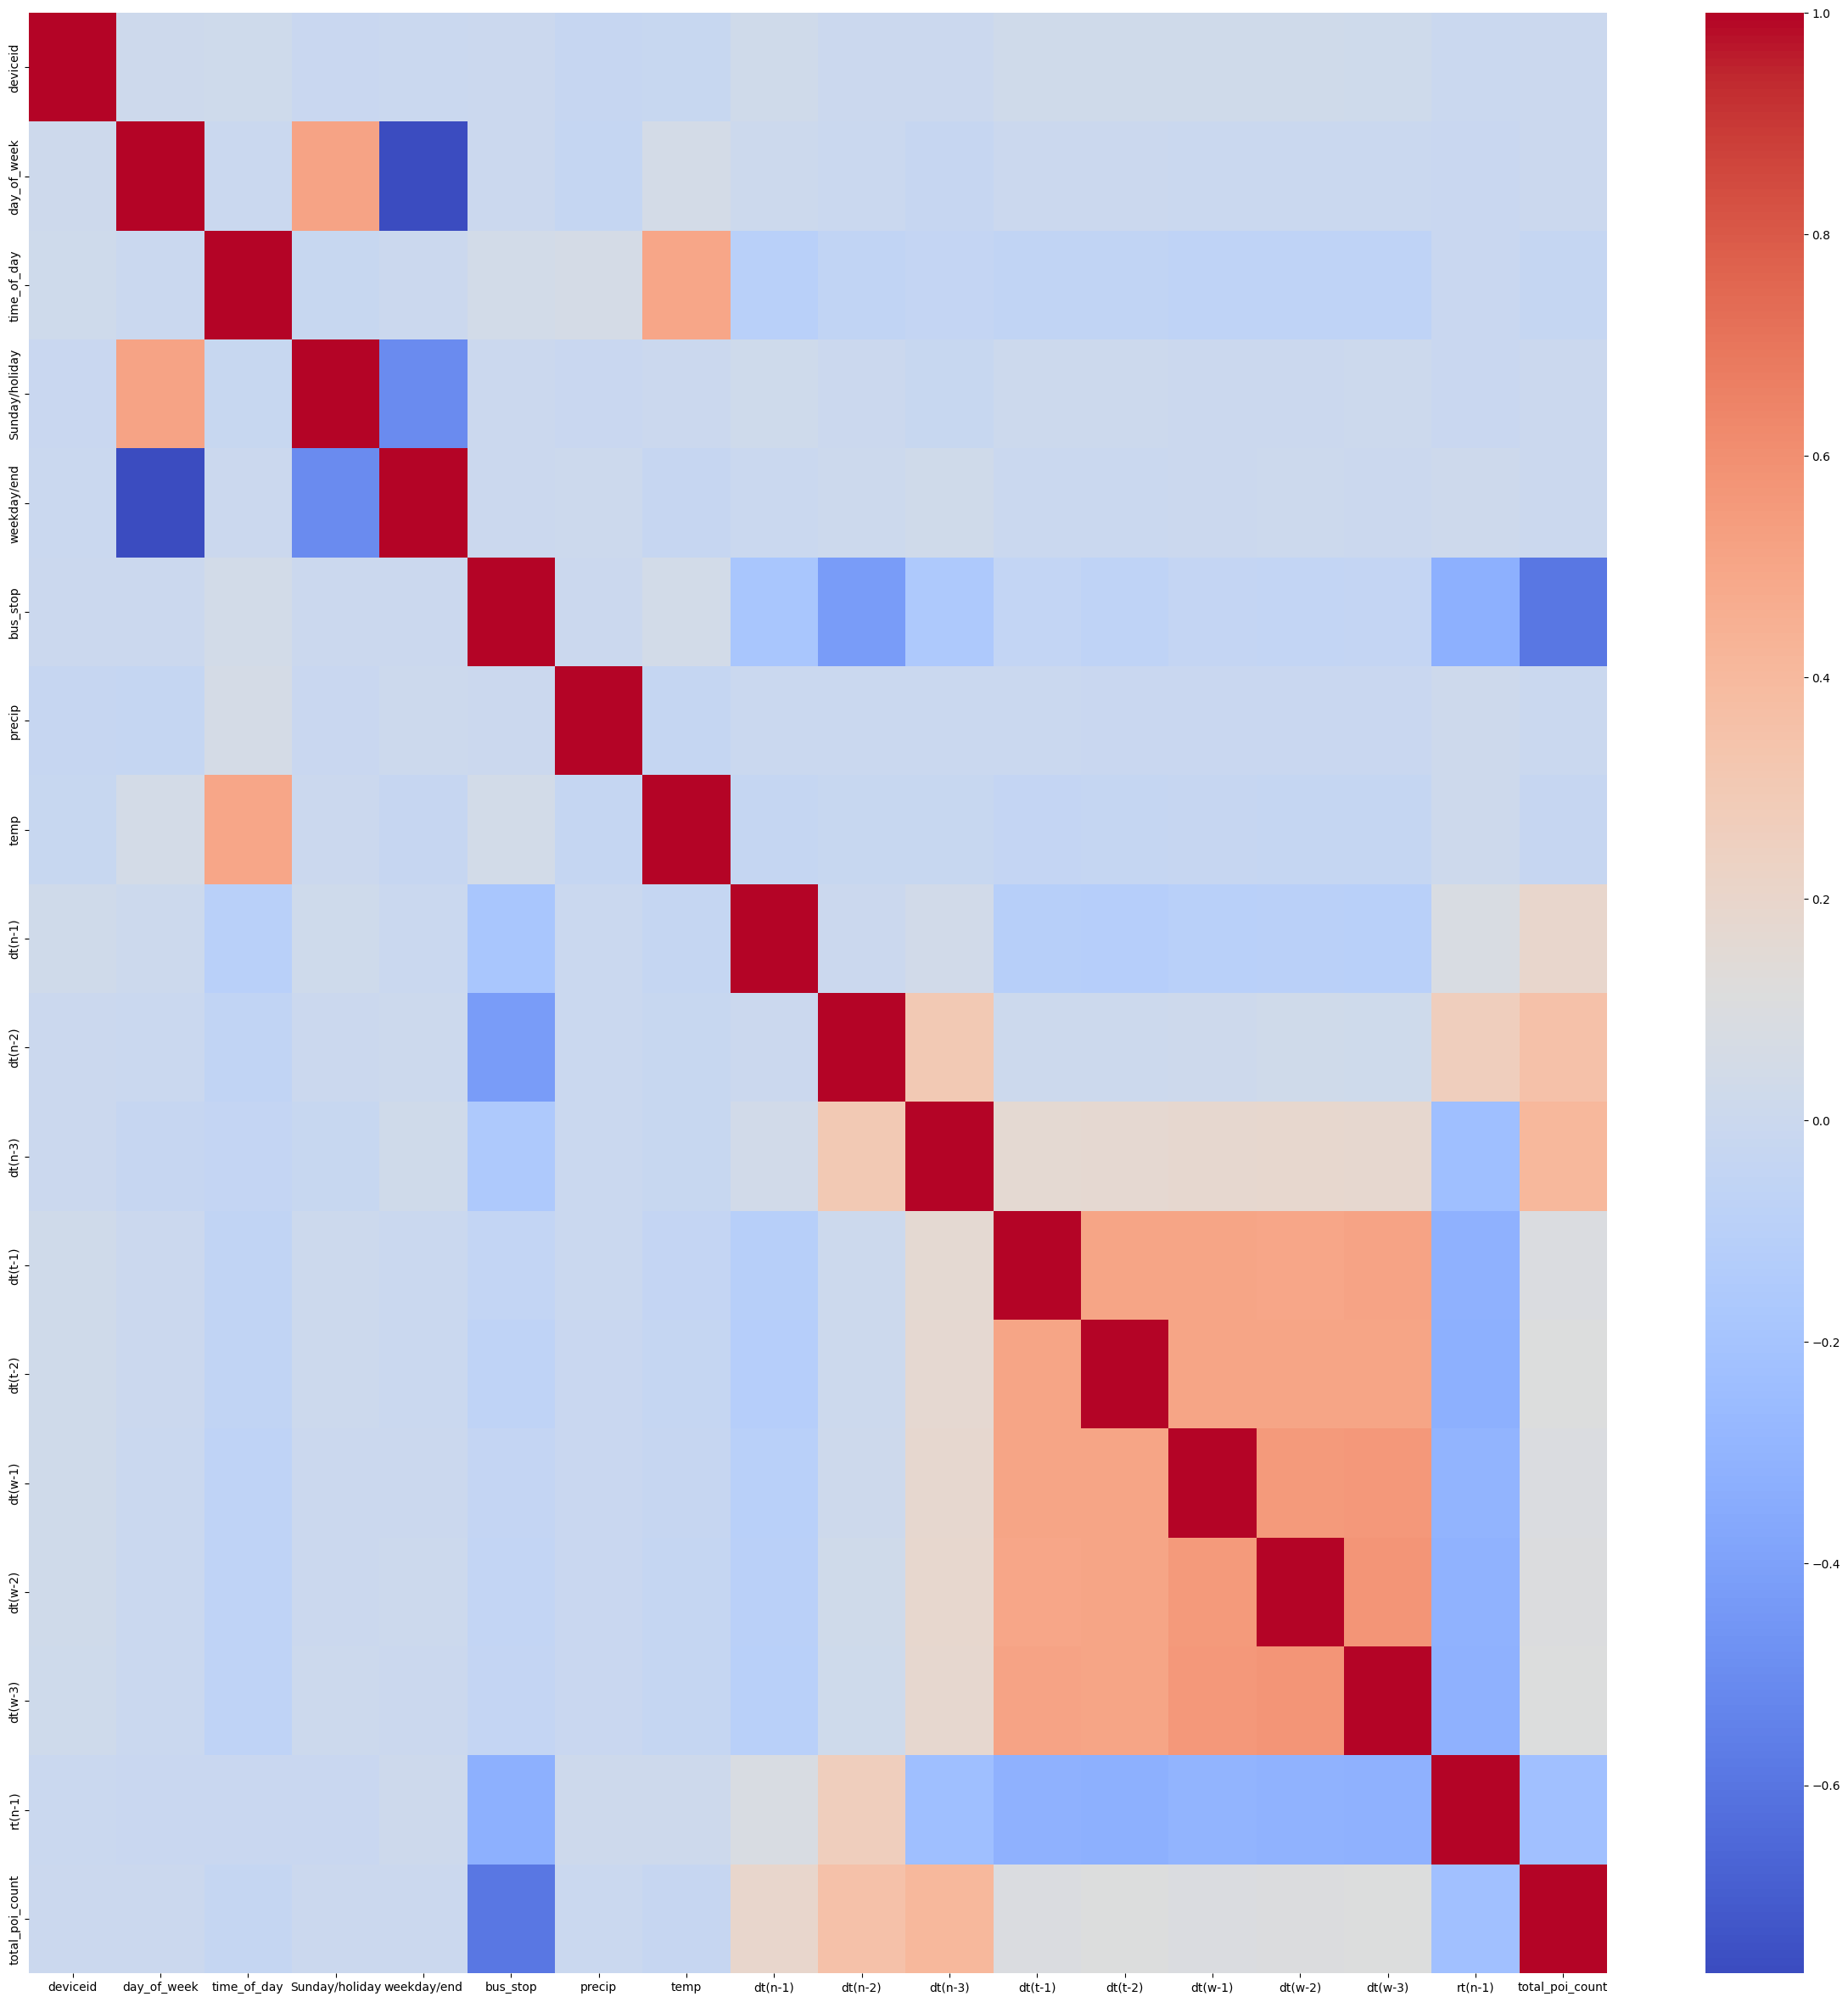

In [16]:
plt.figure(figsize=[30,30])
correlation  = train_dwell_time.corr()
sns.heatmap(data=correlation, cmap = 'coolwarm')

In [17]:
#Scaling
scaler = StandardScaler()
scaler.fit(train_dwell_time)
X_train_scaled = scaler.transform(train_dwell_time)
X_test_scaled = scaler.transform(test_dwell_time)

In [18]:
#Hyperparmeter Grid
parameters = {
    "max_depth": [3,4, 6,5],
    "learning_rate": [0.01, 0.05, 0.1,0.3],
    "n_estimators": [100,150, 200, 300],
    'reg_alpha':[0.001, 0.005, 0.01, 0.05],
    "colsample_bytree": [0.6,0.8,0.9],
    "random_state":[123],
    "eval_metric":['mape']
    
}

In [19]:
cv_split = TimeSeriesSplit(n_splits=6,max_train_size = 2000, test_size=100)
model = xgb.XGBRegressor()
grid_search_cv = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search_cv.fit(X_train_scaled, y_train_dwell_time)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=2000, n_splits=6, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, impo...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 0.9],
                         'eval_metric': ['mape'],
                         'learning_rate': [0.01, 0.05, 0.1, 0.3],
                         'max_depth': [3, 4, 6, 5],
                         'n_estimators': [100, 150, 200, 300],
                         'random_state': [123],
                         'reg_alpha': [0.001, 0.005, 0.01, 0.05]})

In [20]:
dwell_time_model = grid_search_cv.best_estimator_
dwell_time_model.fit(X_train_scaled,y_train_dwell_time)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...)

In [21]:
predictions = dwell_time_model.predict(X_test_scaled)

In [22]:
predictions

array([20.048204 , 12.3188305, 14.4418745, ..., 15.670224 , 14.325334 ,
       18.414507 ], dtype=float32)

#### Model Evaluation

In [23]:
mse = metrics.mean_squared_error(y_test_dwell_time,predictions)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test_dwell_time,predictions)
#mape = metrics.mean_absolute_percentage_error(y_test_dwell_time,predictions)
r2 = metrics.r2_score(y_test_dwell_time,predictions)

In [24]:
print ("Model Evaluation\n")
print ("Mean Squared Error\t: %f\nRoot Mean Squared Error\t: %f\nMean Absolute Error\t: %f\nR-Squared\t: %f"%(mse,rmse,mae,r2))

Model Evaluation

Mean Squared Error	: 1459.271115
Root Mean Squared Error	: 38.200407
Mean Absolute Error	: 19.597074
R-Squared	: 0.140648


In [25]:
dwell_time_model.save_model('dwell_time_model_version_2.json')

In [26]:
predictions_df = pd.DataFrame(predictions,columns=['predicted_dwell_time'])
predictions_df.to_csv('predicted_dwell_times_02.csv')


### Feature Importance Analysis 

In [27]:
x_importance = X_test_scaled
explainer = shap.TreeExplainer(dwell_time_model)
shap_values = explainer.shap_values(x_importance)

In [28]:
shap_data =pd.DataFrame((zip(scaler.get_feature_names_out()[np.argsort(np.abs(shap_values).mean(0))],
np.abs(shap_values).mean(0))), columns=["feature", "importance" ]).sort_values(by="importance", ascending=True)
shap_data.to_csv('shap_running_initial.csv')

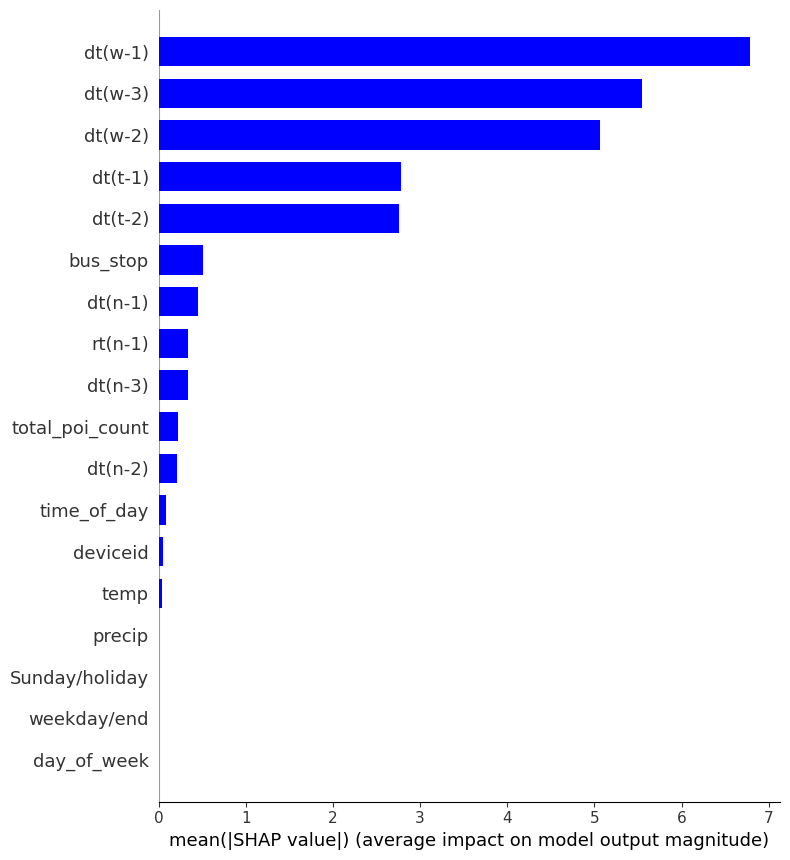

In [29]:
shap.summary_plot(shap_values,x_importance,feature_names=scaler.get_feature_names_out(),color = 'blue',plot_type="bar")